This project will attempt to see if we can predict a country's gross national income by creating a model using the leading causes of death by risk factors. One possible benefit of the resulting model could be to see if eliminating or reducing specific risk factors could have the added benefit of improving the GNI of a country's population. I will be using various data manipulation, statistical analysis, and visualization features from readily available Python libraries. Because this is a cloud based application I also need to install the statistics model each new session

In [1]:
!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import statsmodels.api as sm


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


The data for GNI comes from the world bank. This is our first data set

In [2]:
df_gni_2019 = pd.read_csv('/work/API_NY.GNP.PCAP.CD_DS2_en_csv_v2_5995153.csv', skiprows=3, 
    usecols=['Country Name', 'Country Code', '2019'])
df_gni_2019=df_gni_2019.rename(columns={'2019' : 'GNI per Capita 2019'})
df_gni_2019

,Country Name,Country Code,GNI per Capita 2019
0,Aruba,ABW,30330.000000
1,Africa Eastern and Southern,AFE,1494.589953
2,Afghanistan,AFG,530.000000
3,Africa Western and Central,AFW,1681.824079
4,Angola,AGO,2040.000000
...,...,...,...
261,Kosovo,XKX,4640.000000
262,"Yemen, Rep.",YEM,NaN
263,South Africa,ZAF,6730.000000
264,Zambia,ZMB,1390.000000


The GNI files contains  data from 1960 to 2019. By selecting just the country, country code, and the year 2019 in the read_csv call I eliminate quite a bit of data not needed for this project. 

Not every country reports their data every year.

In [3]:
" How many countries do not report their GNI? "
df_gni_2019.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country Name         266 non-null    object 
 1   Country Code         266 non-null    object 
 2   GNI per Capita 2019  247 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.4+ KB


All the Country Name and  Country Code are not null. However 19 GNI numbers are missing.  Although I could estimate the missing country population I will instead remove the data in a later section. I don't want to mix data sources.

The next data set we want is the number of deaths by risk factor, which comes from "our world in data"

In [4]:
"Read in the risk dataset and reduce to just 2019 data."
df_risk = pd.read_csv('/work/number-of-deaths-by-risk-factor.csv')
df_risk_2019 = df_risk[df_risk['Year'] == 2019]
df_risk_2019 = df_risk_2019.drop(columns=['Year'])
df_risk_2019

,Entity,Code,"Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages","Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages","Deaths that are from all causes attributed to alcohol use, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in fruits, in both sexes aged all ages","Deaths that are from all causes attributed to unsafe water source, in both sexes aged all ages","Deaths that are from all causes attributed to secondhand smoke, in both sexes aged all ages","Deaths that are from all causes attributed to low birth weight, in both sexes aged all ages",...,"Deaths that are from all causes attributed to drug use, in both sexes aged all ages","Deaths that are from all causes attributed to low bone mineral density, in both sexes aged all ages","Deaths that are from all causes attributed to vitamin a deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to child stunting, in both sexes aged all ages","Deaths that are from all causes attributed to non-exclusive breastfeeding, in both sexes aged all ages","Deaths that are from all causes attributed to iron deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to ambient particulate matter pollution, in both sexes aged all ages","Deaths that are from all causes attributed to low physical activity, in both sexes aged all ages","Deaths that are from all causes attributed to no access to handwashing facility, in both sexes aged all ages","Deaths that are from all causes attributed to high ldl cholesterol, in both sexes aged all ages"
29,Afghanistan,AFG,3.601717e+04,1.421833e+03,1.033487e+04,5.830294e+02,4.582984e+03,3.750705e+03,6.061574e+03,2.213249e+04,...,699.909000,631.513850,392.736850,3071.426800,1762.705300,761.420300,8.678681e+03,4117.169000,3941.357700,1.974599e+04
59,African Region (WHO),NaN,7.182989e+05,7.173645e+04,8.823413e+04,2.704413e+05,7.427621e+04,4.922021e+05,6.368820e+04,6.702971e+05,...,36543.453000,26559.559000,18084.240000,107069.050000,86145.690000,20496.781000,2.372350e+05,36619.080000,327472.500000,1.782288e+05
89,Albania,ALB,7.609211e+03,2.444682e+03,1.519789e+03,7.366717e+02,2.171569e+02,3.780118e+00,7.737141e+02,1.058336e+02,...,129.683700,64.898640,0.100605,9.534126,3.896263,0.381268,1.532443e+03,309.929600,8.123295,2.790602e+03
119,Algeria,DZA,5.860158e+04,1.909833e+03,1.477198e+04,1.284973e+03,2.648465e+03,2.769975e+02,7.670411e+03,7.091808e+03,...,1030.342700,1372.259800,2.792199,68.157720,145.736360,93.949870,2.161334e+04,9579.853000,325.857240,2.753402e+04
149,American Samoa,ASM,8.666929e+01,6.474488e+00,1.569039e+01,2.086313e+00,8.181448e+00,2.010538e+00,1.521808e+01,3.224227e+00,...,2.284843,1.620934,0.021888,0.118351,0.102219,0.138421,7.751950e+00,11.770247,0.412116,3.136448e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6719,Western Pacific Region (WHO),NaN,3.252290e+06,9.872528e+05,4.708269e+05,7.204705e+05,2.925508e+05,1.792396e+04,4.977309e+05,7.471637e+04,...,117001.570000,119897.590000,419.601930,4983.520000,4199.928000,896.390140,1.584921e+06,197532.310000,20966.047000,1.161049e+06
6749,World,OWID_WRL,1.084560e+07,1.885356e+06,1.844836e+06,2.441974e+06,1.046015e+06,1.230154e+06,1.304318e+06,1.703121e+06,...,494491.700000,437884.400000,23849.850000,164237.110000,139731.900000,42349.240000,4.140971e+06,831502.000000,627918.900000,4.396984e+06
6779,Yemen,YEM,3.056378e+04,1.240843e+03,9.047844e+03,8.614379e+02,3.609497e+03,5.351433e+03,4.466699e+03,1.717348e+04,...,563.121800,922.904540,202.783540,1315.519500,1984.820000,497.770170,1.128199e+04,3669.953100,2198.282000,1.692054e+04
6809,Zambia,ZMB,1.034032e+04,1.827763e+03,8.727598e+02,6.869730e+03,2.055743e+03,5.915021e+03,9.190534e+02,8.285652e+03,...,394.068600,397

Unlike the GNI data, the risk factors are in long table format. Since I cannot eliminate the unnecessary years by removing columns I instead filter out the unwanted years after reading in the data. I then deleted the year column as all of the remaining data is for the same year.

Now look for missing risk data

In [5]:
df_risk_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 29 to 6839
Data columns (total 30 columns):
 #   Column                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                               --------------  -----  
 0   Entity                                                                                                               228 non-null    object 
 1   Code                                                                                                                 205 non-null    object 
 2   Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages              228 non-null    float64
 3   Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages                       228 non-null    float64
 4   Deaths that 


Some of the country codes are missing, Upon further investigation, these are not
real countries. They are either regions, or part of larger entities, like Scotland being part of Great Britain

In [6]:
" I am dropping the countries that are not official countries from the dataframe"
df_risk_2019 = df_risk_2019[df_risk_2019['Code'].notna()]
df_risk_2019

,Entity,Code,"Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages","Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages","Deaths that are from all causes attributed to alcohol use, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in fruits, in both sexes aged all ages","Deaths that are from all causes attributed to unsafe water source, in both sexes aged all ages","Deaths that are from all causes attributed to secondhand smoke, in both sexes aged all ages","Deaths that are from all causes attributed to low birth weight, in both sexes aged all ages",...,"Deaths that are from all causes attributed to drug use, in both sexes aged all ages","Deaths that are from all causes attributed to low bone mineral density, in both sexes aged all ages","Deaths that are from all causes attributed to vitamin a deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to child stunting, in both sexes aged all ages","Deaths that are from all causes attributed to non-exclusive breastfeeding, in both sexes aged all ages","Deaths that are from all causes attributed to iron deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to ambient particulate matter pollution, in both sexes aged all ages","Deaths that are from all causes attributed to low physical activity, in both sexes aged all ages","Deaths that are from all causes attributed to no access to handwashing facility, in both sexes aged all ages","Deaths that are from all causes attributed to high ldl cholesterol, in both sexes aged all ages"
29,Afghanistan,AFG,3.601717e+04,1.421833e+03,1.033487e+04,5.830294e+02,4.582984e+03,3.750705e+03,6.061574e+03,2.213249e+04,...,699.909000,631.513850,392.736850,3071.426800,1762.705300,761.420300,8.678681e+03,4117.169000,3941.357700,1.974599e+04
89,Albania,ALB,7.609211e+03,2.444682e+03,1.519789e+03,7.366717e+02,2.171569e+02,3.780118e+00,7.737141e+02,1.058336e+02,...,129.683700,64.898640,0.100605,9.534126,3.896263,0.381268,1.532443e+03,309.929600,8.123295,2.790602e+03
119,Algeria,DZA,5.860158e+04,1.909833e+03,1.477198e+04,1.284973e+03,2.648465e+03,2.769975e+02,7.670411e+03,7.091808e+03,...,1030.342700,1372.259800,2.792199,68.157720,145.736360,93.949870,2.161334e+04,9579.853000,325.857240,2.753402e+04
149,American Samoa,ASM,8.666929e+01,6.474488e+00,1.569039e+01,2.086313e+00,8.181448e+00,2.010538e+00,1.521808e+01,3.224227e+00,...,2.284843,1.620934,0.021888,0.118351,0.102219,0.138421,7.751950e+00,11.770247,0.412116,3.136448e+01
179,Andorra,AND,1.006023e+02,5.914475e+00,1.919431e+01,4.034989e+01,4.721110e+00,1.959188e-02,7.639630e+00,2.859738e-01,...,5.993098,12.018740,0.000012,0.000720,0.003609,0.001117,1.056206e+01,12.744569,0.215403,4.111436e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6659,Vietnam,VNM,1.583755e+05,3.215480e+04,1.191471e+04,5.298432e+04,1.513605e+04,1.250594e+03,1.908541e+04,5.286414e+03,...,9605.107000,8389.809000,6.680296,238.600450,246.177170,29.637976,3.745671e+04,5556.346000,2053.345000,4.060291e+04
6749,World,OWID_WRL,1.084560e+07,1.885356e+06,1.844836e+06,2.441974e+06,1.046015e+06,1.230154e+06,1.304318e+06,1.703121e+06,...,494491.700000,437884.400000,23849.850000,164237.110000,139731.900000,42349.240000,4.140971e+06,831502.000000,627918.900000,4.396984e+06
6779,Yemen,YEM,3.056378e+04,1.240843e+03,9.047844e+03,8.614379e+02,3.609497e+03,5.351433e+03,4.466699e+03,1.717348e+04,...,563.121800,922.904540,202.783540,1315.519500,1984.820000,497.770170,1.128199e+04,3669.953100,2198.282000,1.692054e+04
6809,Zambia,ZMB,1.034032e+04,1.827763e+03,8.727598e+02,6.869730e+03,2.055743e+03,5.915021e+03,9.190534e+02,8.285652e+03,...,394.068600,397.834320,112.707770,1088.569100,738.964100,177.371190,2.948648e+03,328.967560,

Code entries that were nan were filtered out using the .nona method

Time to merge the GNI and risk factor data sets together  

In [7]:
"Merge the GNI and risk 2019 data frames"
df_gni_risk_2019 = pd.merge(df_gni_2019, df_risk_2019,  left_on=['Country Code'], 
    right_on=['Code'], how='inner').sort_values(by=['Country Code'])
df_gni_risk_2019.drop(columns=['Entity', 'Code'],inplace=True)
df_gni_risk_2019

,Country Name,Country Code,GNI per Capita 2019,"Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages","Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages","Deaths that are from all causes attributed to alcohol use, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in fruits, in both sexes aged all ages","Deaths that are from all causes attributed to unsafe water source, in both sexes aged all ages","Deaths that are from all causes attributed to secondhand smoke, in both sexes aged all ages",...,"Deaths that are from all causes attributed to drug use, in both sexes aged all ages","Deaths that are from all causes attributed to low bone mineral density, in both sexes aged all ages","Deaths that are from all causes attributed to vitamin a deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to child stunting, in both sexes aged all ages","Deaths that are from all causes attributed to non-exclusive breastfeeding, in both sexes aged all ages","Deaths that are from all causes attributed to iron deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to ambient particulate matter pollution, in both sexes aged all ages","Deaths that are from all causes attributed to low physical activity, in both sexes aged all ages","Deaths that are from all causes attributed to no access to handwashing facility, in both sexes aged all ages","Deaths that are from all causes attributed to high ldl cholesterol, in both sexes aged all ages"
0,Afghanistan,AFG,530.0,36017.170000,1421.832900,10334.86600,583.029400,4582.98400,3750.705300,6061.57370,...,699.909000,631.513850,392.736850,3071.426800,1762.705300,761.420300,8678.681000,4117.169000,3941.357700,19745.98800
1,Angola,AGO,2040.0,17685.701000,1288.708700,2012.97470,11905.777000,1579.26840,11143.476000,1634.33590,...,557.254900,718.003660,322.666080,1824.149400,1680.036700,390.805050,5562.778300,796.063700,7009.183600,3963.95800
2,Albania,ALB,5230.0,7609.211400,2444.682100,1519.78900,736.671750,217.15688,3.780118,773.71410,...,129.683700,64.898640,0.100605,9.534126,3.896263,0.381268,1532.443100,309.929600,8.123295,2790.60180
3,Andorra,AND,46530.0,100.602325,5.914475,19.19431,40.349888,4.72111,0.019592,7.63963,...,5.993098,12.018740,0.000012,0.000720,0.003609,0.001117,10.562062,12.744569,0.215403,41.11436
4,United Arab Emirates,ARE,46210.0,5982.615000,292.741000,1469.56470,552.830200,323.20053,26.035597,936.59467,...,1007.800300,367.049470,0.004012,0.515542,0.687960,1.755508,3251.870400,1119.828400,26.580946,3909.62350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,Samoa,WSM,4230.0,317.410830,20.181269,69.76570,26.144106,38.65176,6.636838,66.26775,...,8.754262,6.415719,0.549960,0.621315,0.472366,0.150450,40.660820,36.679447,1.796120,122.12530
196,"Yemen, Rep.",YEM,NaN,30563.783000,1240.842800,9047.84400,861.437870,3609.49660,5351.432600,4466.69900,...,563.121800,922.904540,202.783540,1315.519500,1984.820000,497.770170,11281.991000,3669.953100,2198.282000,16920.54000
197,South Africa,ZAF,6730.0,61472.863000,3290.505000,5242.76270,27059.635000,8375.05800,9506.172000,7297.43500,...,5485.943400,1821.172600,73.837620,850.279400,1570.945900,297.717900,24779.957000,5960.987300,7427.963000,14727.17600
198,Zambia,ZMB,1390.0,10340.324000,1827.762700,872.75980,6869.730000,2055.74320,5915.021500,919.05340,...,394.068600,397.834320,112.707770,1088.569100,738.964100,177.371190,2948.647500,328.967560,3975.220000,2112.26600


The data frames were merged using an inner join, on the value for country code. After the join the duplicate column names were dropped.

There should be 205 entries, but only ended up with 200. That means 5 country names did not match

In [8]:
"Investigate why there are 5 missing entries"
mismatch = df_risk_2019[~df_risk_2019['Code'].isin(df_gni_2019['Country Code'])]
mismatch

,Entity,Code,"Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages","Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages","Deaths that are from all causes attributed to alcohol use, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in fruits, in both sexes aged all ages","Deaths that are from all causes attributed to unsafe water source, in both sexes aged all ages","Deaths that are from all causes attributed to secondhand smoke, in both sexes aged all ages","Deaths that are from all causes attributed to low birth weight, in both sexes aged all ages",...,"Deaths that are from all causes attributed to drug use, in both sexes aged all ages","Deaths that are from all causes attributed to low bone mineral density, in both sexes aged all ages","Deaths that are from all causes attributed to vitamin a deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to child stunting, in both sexes aged all ages","Deaths that are from all causes attributed to non-exclusive breastfeeding, in both sexes aged all ages","Deaths that are from all causes attributed to iron deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to ambient particulate matter pollution, in both sexes aged all ages","Deaths that are from all causes attributed to low physical activity, in both sexes aged all ages","Deaths that are from all causes attributed to no access to handwashing facility, in both sexes aged all ages","Deaths that are from all causes attributed to high ldl cholesterol, in both sexes aged all ages"
1289,Cook Islands,COK,4.150273e+01,7.032040e+00,6.028022e+00,7.416185e+00,2.728691e+00,3.852834e-01,7.698646e+00,1.149451e-01,...,1.028447,0.803482,0.000688,0.006394,0.005623,0.001341,3.050883e+00,5.621836,0.222135,1.208477e+01
4349,Niue,NIU,5.267443e+00,8.452141e-01,9.882727e-01,3.799937e-01,5.134809e-01,9.070000e-02,1.006239e+00,1.339474e-01,...,0.123922,0.091034,0.000265,0.004955,0.004581,0.002572,4.605621e-01,0.690152,0.025060,1.947583e+00
5999,Taiwan,TWN,2.569500e+04,5.005322e+03,5.035089e+03,1.119233e+04,1.416927e+03,3.545267e+01,5.029659e+03,2.523210e+02,...,2257.981000,1421.105500,0.005680,1.350924,2.855274,2.469951,1.158303e+04,3113.711200,240.977840,9.262364e+03
6149,Tokelau,TKL,2.559496e+00,4.343701e-01,5.177773e-01,1.701279e-01,3.082936e-01,7.960739e-02,5.304401e-01,6.554637e-02,...,0.066845,0.050526,0.001557,0.004724,0.002780,0.004180,2.117980e-01,0.331118,0.019619,1.099960e+00
6749,World,OWID_WRL,1.084560e+07,1.885356e+06,1.844836e+06,2.441974e+06,1.046015e+06,1.230154e+06,1.304318e+06,1.703121e+06,...,494491.700000,437884.400000,23849.850000,164237.110000,139731.900000,42349.240000,4.140971e+06,831502.000000,627918.900000,4.396984e+06


World is clearly not a country. Cook, Niue, and Tokelau are small and apparently did not make
the cut from the world bank. Taiwan's omission is likely a political statement. I could manually add
the data for Taiwan and redo the merge, but since I am going to focus on lower income countries Taiwan would
have been removed anyway, so I will not bother adding it in.

In [9]:
" Check for missing GNI data"
df_gni_risk_2019['GNI per Capita 2019'].isna().sum()

11

The countries with missing GNI data stopped reporting their data to the World Bank. Inserting GNI data for these countries from another source would mixing data sources. Instead I will drop these countries.

In [10]:
df_gni_risk_2019.dropna(subset=['GNI per Capita 2019'],inplace=True)
df_gni_risk_2019

,Country Name,Country Code,GNI per Capita 2019,"Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages","Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages","Deaths that are from all causes attributed to alcohol use, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in fruits, in both sexes aged all ages","Deaths that are from all causes attributed to unsafe water source, in both sexes aged all ages","Deaths that are from all causes attributed to secondhand smoke, in both sexes aged all ages",...,"Deaths that are from all causes attributed to drug use, in both sexes aged all ages","Deaths that are from all causes attributed to low bone mineral density, in both sexes aged all ages","Deaths that are from all causes attributed to vitamin a deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to child stunting, in both sexes aged all ages","Deaths that are from all causes attributed to non-exclusive breastfeeding, in both sexes aged all ages","Deaths that are from all causes attributed to iron deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to ambient particulate matter pollution, in both sexes aged all ages","Deaths that are from all causes attributed to low physical activity, in both sexes aged all ages","Deaths that are from all causes attributed to no access to handwashing facility, in both sexes aged all ages","Deaths that are from all causes attributed to high ldl cholesterol, in both sexes aged all ages"
0,Afghanistan,AFG,530.0,36017.170000,1421.832900,10334.86600,583.029400,4582.98400,3750.705300,6061.57370,...,699.909000,631.513850,392.736850,3071.426800,1762.705300,761.420300,8678.681000,4117.169000,3941.357700,19745.98800
1,Angola,AGO,2040.0,17685.701000,1288.708700,2012.97470,11905.777000,1579.26840,11143.476000,1634.33590,...,557.254900,718.003660,322.666080,1824.149400,1680.036700,390.805050,5562.778300,796.063700,7009.183600,3963.95800
2,Albania,ALB,5230.0,7609.211400,2444.682100,1519.78900,736.671750,217.15688,3.780118,773.71410,...,129.683700,64.898640,0.100605,9.534126,3.896263,0.381268,1532.443100,309.929600,8.123295,2790.60180
3,Andorra,AND,46530.0,100.602325,5.914475,19.19431,40.349888,4.72111,0.019592,7.63963,...,5.993098,12.018740,0.000012,0.000720,0.003609,0.001117,10.562062,12.744569,0.215403,41.11436
4,United Arab Emirates,ARE,46210.0,5982.615000,292.741000,1469.56470,552.830200,323.20053,26.035597,936.59467,...,1007.800300,367.049470,0.004012,0.515542,0.687960,1.755508,3251.870400,1119.828400,26.580946,3909.62350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,Vanuatu,VUT,3590.0,596.281500,86.356160,103.00508,45.699870,53.32458,55.862766,63.53861,...,16.720910,7.498769,1.188278,4.827860,3.894516,1.632568,54.430035,23.670769,21.858908,243.94410
195,Samoa,WSM,4230.0,317.410830,20.181269,69.76570,26.144106,38.65176,6.636838,66.26775,...,8.754262,6.415719,0.549960,0.621315,0.472366,0.150450,40.660820,36.679447,1.796120,122.12530
197,South Africa,ZAF,6730.0,61472.863000,3290.505000,5242.76270,27059.635000,8375.05800,9506.172000,7297.43500,...,5485.943400,1821.172600,73.837620,850.279400,1570.945900,297.717900,24779.957000,5960.987300,7427.963000,14727.17600
198,Zambia,ZMB,1390.0,10340.324000,1827.762700,872.75980,6869.730000,2055.74320,5915.021500,919.05340,...,394.068600,397.834320,112.707770,1088.569100,738.964100,177.371190,2948.647500,328.967560,3975.220000,2112.26600


Used the dropna method to remove rows that had missing GNI data

The third and final data set to read and merge is population data from the world bank. The death numbers are all absolute numbers. The population will be used to calculate the deaths per 100,000 people. 

In [11]:
" Read in World Bank population data and filter to 2019"
df_pop_2019 = pd.read_csv('/work/API_SP.POP.TOTL_DS2_en_csv_v2_6011311.csv', skiprows=3, 
    usecols=['Country Name','Country Code', '2019'])
df_pop_2019=df_pop_2019.rename(columns={'2019' : 'Population 2019'})
df_pop_2019


,Country Name,Country Code,Population 2019
0,Aruba,ABW,106442.0
1,Africa Eastern and Southern,AFE,667242986.0
2,Afghanistan,AFG,37769499.0
3,Africa Western and Central,AFW,454306063.0
4,Angola,AGO,32353588.0
...,...,...,...
261,Kosovo,XKX,1788878.0
262,"Yemen, Rep.",YEM,31546691.0
263,South Africa,ZAF,58087055.0
264,Zambia,ZMB,18380477.0


Similar to the GNI data set, only read in the 2019 year of data using the usecols parameter of read_csv.

The second and final merge of the GNI and risk data frame with the population data frame

In [12]:
" Merge population data with our risk-GNI data set "
df_gni_risk_pop_2019 = pd.merge(df_gni_risk_2019, df_pop_2019,  
    on=['Country Name','Country Code'], how='inner').sort_values(by=['Country Name'])
df_gni_risk_pop_2019

,Country Name,Country Code,GNI per Capita 2019,"Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages","Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages","Deaths that are from all causes attributed to alcohol use, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in fruits, in both sexes aged all ages","Deaths that are from all causes attributed to unsafe water source, in both sexes aged all ages","Deaths that are from all causes attributed to secondhand smoke, in both sexes aged all ages",...,"Deaths that are from all causes attributed to low bone mineral density, in both sexes aged all ages","Deaths that are from all causes attributed to vitamin a deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to child stunting, in both sexes aged all ages","Deaths that are from all causes attributed to non-exclusive breastfeeding, in both sexes aged all ages","Deaths that are from all causes attributed to iron deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to ambient particulate matter pollution, in both sexes aged all ages","Deaths that are from all causes attributed to low physical activity, in both sexes aged all ages","Deaths that are from all causes attributed to no access to handwashing facility, in both sexes aged all ages","Deaths that are from all causes attributed to high ldl cholesterol, in both sexes aged all ages",Population 2019
0,Afghanistan,AFG,530.0,36017.170000,1421.832900,10334.86600,583.029400,4582.98400,3750.705300,6061.57370,...,631.513850,392.736850,3071.426800,1762.705300,761.420300,8678.681000,4117.169000,3941.357700,19745.98800,37769499.0
2,Albania,ALB,5230.0,7609.211400,2444.682100,1519.78900,736.671750,217.15688,3.780118,773.71410,...,64.898640,0.100605,9.534126,3.896263,0.381268,1532.443100,309.929600,8.123295,2790.60180,2854191.0
50,Algeria,DZA,4050.0,58601.582000,1909.833100,14771.98000,1284.973400,2648.46480,276.997470,7670.41100,...,1372.259800,2.792199,68.157720,145.736360,93.949870,21613.342000,9579.853000,325.857240,27534.02100,42705368.0
3,Andorra,AND,46530.0,100.602325,5.914475,19.19431,40.349888,4.72111,0.019592,7.63963,...,12.018740,0.000012,0.000720,0.003609,0.001117,10.562062,12.744569,0.215403,41.11436,76343.0
1,Angola,AGO,2040.0,17685.701000,1288.708700,2012.97470,11905.777000,1579.26840,11143.476000,1634.33590,...,718.003660,322.666080,1824.149400,1680.036700,390.805050,5562.778300,796.063700,7009.183600,3963.95800,32353588.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,Vanuatu,VUT,3590.0,596.281500,86.356160,103.00508,45.699870,53.32458,55.862766,63.53861,...,7.498769,1.188278,4.827860,3.894516,1.632568,54.430035,23.670769,21.858908,243.94410,304404.0
183,Viet Nam,VNM,3340.0,158375.450000,32154.800000,11914.71000,52984.324000,15136.05400,1250.593800,19085.41200,...,8389.809000,6.680296,238.600450,246.177170,29.637976,37456.710000,5556.346000,2053.345000,40602.90600,95776716.0
142,West Bank and Gaza,PSE,4270.0,3815.996300,142.638580,1181.07080,219.410400,329.41990,21.366780,615.27650,...,59.958370,0.355769,3.678022,6.848289,2.717332,1791.709400,717.704200,39.108520,2107.76780,4685306.0
187,Zambia,ZMB,1390.0,10340.324000,1827.762700,872.75980,6869.730000,2055.74320,5915.021500,919.05340,...,397.834320,112.707770,1088.569100,738.964100,177.371190,2948.647500,328.967560,3975.220000,2112.26600,18380477.0


We don't want the developed countries to skew the data. We would like to make it easier to see how low GNI countries might get to medium GNI.  The pivot point can easily be changed.

In [13]:
" Filter by GNI "
pivot_gni = df_gni_2019['GNI per Capita 2019'].apply('median')
df_gni_risk_pop_2019_lower = df_gni_risk_pop_2019[df_gni_risk_pop_2019['GNI per Capita 2019'] <= pivot_gni]
df_gni_risk_pop_2019_lower

,Country Name,Country Code,GNI per Capita 2019,"Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages","Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages","Deaths that are from all causes attributed to alcohol use, in both sexes aged all ages","Deaths that are from all causes attributed to diet low in fruits, in both sexes aged all ages","Deaths that are from all causes attributed to unsafe water source, in both sexes aged all ages","Deaths that are from all causes attributed to secondhand smoke, in both sexes aged all ages",...,"Deaths that are from all causes attributed to low bone mineral density, in both sexes aged all ages","Deaths that are from all causes attributed to vitamin a deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to child stunting, in both sexes aged all ages","Deaths that are from all causes attributed to non-exclusive breastfeeding, in both sexes aged all ages","Deaths that are from all causes attributed to iron deficiency, in both sexes aged all ages","Deaths that are from all causes attributed to ambient particulate matter pollution, in both sexes aged all ages","Deaths that are from all causes attributed to low physical activity, in both sexes aged all ages","Deaths that are from all causes attributed to no access to handwashing facility, in both sexes aged all ages","Deaths that are from all causes attributed to high ldl cholesterol, in both sexes aged all ages",Population 2019
0,Afghanistan,AFG,530.0,36017.1700,1421.83290,10334.86600,583.02940,4582.98400,3750.705300,6061.57370,...,631.513850,392.736850,3071.426800,1762.705300,761.420300,8678.681000,4117.169000,3941.357700,19745.9880,37769499.0
2,Albania,ALB,5230.0,7609.2114,2444.68210,1519.78900,736.67175,217.15688,3.780118,773.71410,...,64.898640,0.100605,9.534126,3.896263,0.381268,1532.443100,309.929600,8.123295,2790.6018,2854191.0
50,Algeria,DZA,4050.0,58601.5820,1909.83310,14771.98000,1284.97340,2648.46480,276.997470,7670.41100,...,1372.259800,2.792199,68.157720,145.736360,93.949870,21613.342000,9579.853000,325.857240,27534.0210,42705368.0
1,Angola,AGO,2040.0,17685.7010,1288.70870,2012.97470,11905.77700,1579.26840,11143.476000,1634.33590,...,718.003660,322.666080,1824.149400,1680.036700,390.805050,5562.778300,796.063700,7009.183600,3963.9580,32353588.0
6,Armenia,ARM,4880.0,7789.3223,1061.80650,2445.83370,801.58600,319.25280,2.788322,1006.16110,...,64.626150,0.005022,7.377565,9.448921,1.085729,3090.598000,595.678040,21.463055,3455.0400,2820602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,Vanuatu,VUT,3590.0,596.2815,86.35616,103.00508,45.69987,53.32458,55.862766,63.53861,...,7.498769,1.188278,4.827860,3.894516,1.632568,54.430035,23.670769,21.858908,243.9441,304404.0
183,Viet Nam,VNM,3340.0,158375.4500,32154.80000,11914.71000,52984.32400,15136.05400,1250.593800,19085.41200,...,8389.809000,6.680296,238.600450,246.177170,29.637976,37456.710000,5556.346000,2053.345000,40602.9060,95776716.0
142,West Bank and Gaza,PSE,4270.0,3815.9963,142.63858,1181.07080,219.41040,329.41990,21.366780,615.27650,...,59.958370,0.355769,3.678022,6.848289,2.717332,1791.709400,717.704200,39.108520,2107.7678,4685306.0
187,Zambia,ZMB,1390.0,10340.3240,1827.76270,872.75980,6869.73000,2055.74320,5915.021500,919.05340,...,397.834320,112.707770,1088.569100,738.964100,177.371190,2948.647500,328.967560,3975.220000,2112.2660,18380477.0


Filtered the data frame to only include counties with GNI below the median GNI of all countries.  Used the apply method with the function median. This lowered the number of countries we are modeling to 98.

Convert the risk factors to deaths per 100,000

In [14]:

deathrateper100K = df_gni_risk_pop_2019_lower.iloc[:,2:31]
deathrateper100K.iloc[:,1:29] = deathrateper100K.iloc[:,1:29].div(df_gni_risk_pop_2019_lower.loc[:,'Population 2019'],axis=0)*100000
deathrateper100K.columns = deathrateper100K.columns.str.replace('Deaths that are from all causes attributed to ',"Deaths ...")
deathrateper100K

,GNI per Capita 2019,"Deaths ...high systolic blood pressure, in both sexes aged all ages","Deaths ...diet high in sodium, in both sexes aged all ages","Deaths ...diet low in whole grains, in both sexes aged all ages","Deaths ...alcohol use, in both sexes aged all ages","Deaths ...diet low in fruits, in both sexes aged all ages","Deaths ...unsafe water source, in both sexes aged all ages","Deaths ...secondhand smoke, in both sexes aged all ages","Deaths ...low birth weight, in both sexes aged all ages","Deaths ...child wasting, in both sexes aged all ages",...,"Deaths ...drug use, in both sexes aged all ages","Deaths ...low bone mineral density, in both sexes aged all ages","Deaths ...vitamin a deficiency, in both sexes aged all ages","Deaths ...child stunting, in both sexes aged all ages","Deaths ...non-exclusive breastfeeding, in both sexes aged all ages","Deaths ...iron deficiency, in both sexes aged all ages","Deaths ...ambient particulate matter pollution, in both sexes aged all ages","Deaths ...low physical activity, in both sexes aged all ages","Deaths ...no access to handwashing facility, in both sexes aged all ages","Deaths ...high ldl cholesterol, in both sexes aged all ages"
0,530.0,95.360465,3.764500,27.362995,1.543651,12.134087,9.930514,16.048859,58.598845,32.525645,...,1.853106,1.672021,1.039825,8.132029,4.667007,2.015966,22.978015,10.900777,10.435293,52.280249
2,5230.0,266.597835,85.652365,53.247628,25.810177,7.608351,0.132441,27.108000,3.708008,1.165086,...,4.543624,2.273802,0.003525,0.334040,0.136510,0.013358,53.690979,10.858755,0.284609,97.772076
50,4050.0,137.222988,4.472115,34.590452,3.008927,6.201714,0.648624,17.961234,16.606361,1.744341,...,2.412677,3.213319,0.006538,0.159600,0.341260,0.219995,50.610364,22.432433,0.763036,64.474379
1,2040.0,54.663801,3.983202,6.221797,36.798939,4.881277,34.442783,5.051483,49.071154,33.276553,...,1.722390,2.219240,0.997312,5.638167,5.192737,1.207919,17.193698,2.460511,21.664316,12.251989
6,4880.0,276.158150,37.644677,86.713180,28.418969,11.318605,0.098856,35.671857,4.723859,1.653864,...,3.398442,2.291218,0.000178,0.261560,0.334997,0.038493,109.572283,21.118826,0.760939,122.493000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,3590.0,195.884910,28.368931,33.838281,15.012901,17.517700,18.351522,20.873119,18.567851,11.872581,...,5.492999,2.463427,0.390362,1.586004,1.279391,0.536316,17.880854,7.776103,7.180887,80.138270
183,3340.0,165.359032,33.572669,12.440090,55.320673,15.803480,1.305739,19.926985,5.519519,1.604762,...,10.028645,8.759758,0.006975,0.249122,0.257032,0.030945,39.108367,5.801354,2.143887,42.393295
142,4270.0,81.446042,3.044381,25.207976,4.682947,7.030915,0.456038,13.132045,13.386555,0.959294,...,1.032360,1.279711,0.007593,0.078501,0.146165,0.057997,38.241033,15.318193,0.834706,44.986769
187,1390.0,56.257104,9.944044,4.748298,37.375145,11.184384,32.181001,5.000161,45.078547,34.622336,...,2.143952,2.164440,0.613193,5.922420,4.020375,0.964998,16.042280,1.789766,21.627404,11.491900


Created a data frame with just the dependent variable (GNI) and the dependent variables(risk factors), divide by the population and then multiplied by 100,000. That gives us deaths per 100,000

In order to create a first order linear model I am going to do do a  stepwise linear regression. This means I will create a simple linear model for each variable individually. I will take the model whose variable has  the smallest t-test p-value and put that in my model. I will then create two variable models using my first selected variable and add each of the remaining variables. I then pick the second variable from my model with the lowest p-value. This will continue until the R-squared adjusted value stops increasing or I run out of variables. 

In [15]:
modelstats = []
yhat = deathrateper100K['GNI per Capita 2019']
xvars = deathrateper100K.iloc[:,1:30]
midx = 1
modelVars = pd.DataFrame()
max_rsq_adj = 0
best_model = pd.DataFrame()
best_model[['risk']] = ""
best_model[['RsqAdj']] = ""

In [16]:
for i in range(28):
    modelstats = []

    for column in xvars:
        xs=pd.concat([modelVars,xvars[column]],axis=1)

        # Add a constant to the dependent variables first
        xs = sm.add_constant(xs)

        # Build the model
        model = sm.OLS(yhat, xs).fit()

        data = {'risk' : column, 'B0' : model.pvalues[0], 'B1' : model.pvalues[midx],  'RsqAdj' : model.rsquared_adj}

        modelstats.append(data)

    midx += 1
    df_modelstats = pd.DataFrame(modelstats)
    idx = df_modelstats['B1'].idxmin()
    rsq = df_modelstats['RsqAdj'].iloc[idx]

    if rsq > max_rsq_adj :
        modelVars = pd.concat([modelVars,xvars.iloc[:,idx]],axis=1)
        xvars=xvars.drop(xvars.columns[idx],axis=1)
        max_rsq_adj = rsq
        best_model.loc[len(best_model.index)] = df_modelstats.iloc[idx,[0,3]]
    else :
        break
   

df_modelstats

,risk,B0,B1,RsqAdj
0,"Deaths ...high systolic blood pressure, in bot...",1.710979e-11,0.710004,0.673502
1,"Deaths ...diet high in sodium, in both sexes a...",1.498315e-11,0.591781,0.674086
2,"Deaths ...unsafe water source, in both sexes a...",1.744410e-11,0.959056,0.672972
3,"Deaths ...secondhand smoke, in both sexes aged...",2.809810e-11,0.822455,0.673158
4,"Deaths ...unsafe sex, in both sexes aged all ages",1.466709e-11,0.724088,0.673449
5,"Deaths ...air pollution, in both sexes aged al...",6.828053e-10,0.613745,0.673958
6,"Deaths ...unsafe sanitation, in both sexes age...",2.090565e-11,0.725659,0.673443
7,"Deaths ...drug use, in both sexes aged all ages",9.706580e-12,0.334796,0.676585
8,"Deaths ...low bone mineral density, in both se...",4.743484e-08,0.369567,0.676099
9,"Deaths ...vitamin a deficiency, in both sexes ...",1.562702e-11,0.789178,0.673241


I used nested for loops. The inner loop created a model with every remaining available variable. The outer loop picks the variable with the lowest p-value and adds it to the model. The variable is removed from the list of remaining variables The outer loop stops when the R squared adjust value stops increasing. The R-squared adjusted value tells us the  proportion of variance in the dependent variable (GNI) that can be explained by the independent variables (risk). The higher the score the better. A score of one means the model perfectly predicts each dependent variable data point.

In [17]:
best_model

,risk,RsqAdj
0,"Deaths ...low birth weight, in both sexes aged...",0.450543
1,"Deaths ...high body-mass index, in both sexes ...",0.538050
2,Deaths ...household air pollution from solid f...,0.589194
3,"Deaths ...diet low in nuts and seeds, in both ...",0.628858
4,"Deaths ...high fasting plasma glucose, in both...",0.638178
5,"Deaths ...child wasting, in both sexes aged al...",0.644272
6,"Deaths ...no access to handwashing facility, i...",0.657950
7,"Deaths ...alcohol use, in both sexes aged all ...",0.670090
8,"Deaths ...diet low in fruits, in both sexes ag...",0.671346
9,"Deaths ...diet low in vegetables, in both sexe...",0.673737


Our final model is made up of the model variables

In [18]:
xs = modelVars

# Add a constant to the dependent variables first
xs = sm.add_constant(xs)

# Build the model
model = sm.OLS(yhat, xs).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     GNI per Capita 2019   R-squared:                       0.717
Model:                             OLS   Adj. R-squared:                  0.677
Method:                  Least Squares   F-statistic:                     17.93
Date:                 Thu, 14 Dec 2023   Prob (F-statistic):           1.66e-18
Time:                         22:04:56   Log-Likelihood:                -812.25
No. Observations:                   98   AIC:                             1651.
Df Residuals:                       85   BIC:                             1684.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
===================================================================================================================================================
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                            2914.5393    371.561      7.844      0.000    2175.776    3653.303
Deaths ...low birth weight, in both sexes aged all ages                           -10.9583      8.295     -1.321      0.190     -27.451       5.534
Deaths ...high body-mass index, in both sexes aged all ages                         8.3047      7.152      1.161      0.249      -5.915      22.524
Deaths ...household air pollution from solid fuels, in both sexes aged all ages   -25.4300      6.419     -3.962      0.000     -38.193     -12.667
Deaths ...diet low in nuts and seeds, in both sexes aged all ages                 -17.4441     27.080     -0.644      0.521     -71.287      36.399
Deaths ...high fasting plasma glucose, in both sexes aged all ages                  7.9236      4.954      1.599      0.113      -1.927      17.774
Deaths ...child wasting, in both sexes aged all ages                               30.6993      8.825      3.479      0.001      13.153      48.246
Deaths ...no access to handwashing facility, in both sexes aged all ages          -54.5634     20.526     -2.658      0.009     -95.374     -13.753
Deaths ...alcohol use, in both sexes aged all ages                                 11.6200      6.767      1.717      0.090      -1.834      25.074
Deaths ...diet low in fruits, in both sexes aged all ages                         -45.0872     25.797     -1.748      0.084     -96.379       6.204
Deaths ...diet low in vegetables, in both sexes aged all ages                      48.1847     36.039      1.337      0.185     -23.470     119.839
Deaths ...smoking, in both sexes aged all ages                                      6.1638      4.433      1.391      0.168      -2.649      14.977
Deaths ...diet low in whole grains, in both sexes aged all ages                   -15.9180     14.626     -1.088      0.280     -44.998      13.162
==============================================================================
Omnibus:                        2.032   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.362   Jarque-Bera (JB):                1.583
Skew:                           0.070   Prob(JB):                        0.453
Kurtosis:                       3.607   Cond. No.                         627.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The stats model OLS (ordinary simple model) created our model. The summary gives us the individual slope and p-values for each of the predictors. Some of the p-values are higher than we would prefer. We typically look for numbers less than .05, which means a less than 5% chance the slope is not zero (meaningful). However for this project I am looking for the best model prediction which is the model with the highest R squared adjusted score.

Now that we have a model we want to see if the assumptions pertaining to residuals hold true. The residuals measure the difference between predicted values and actual values.One assumption is that the variance of the residuals is constant.   One such test is to plot the residuals versus the fitted model. 

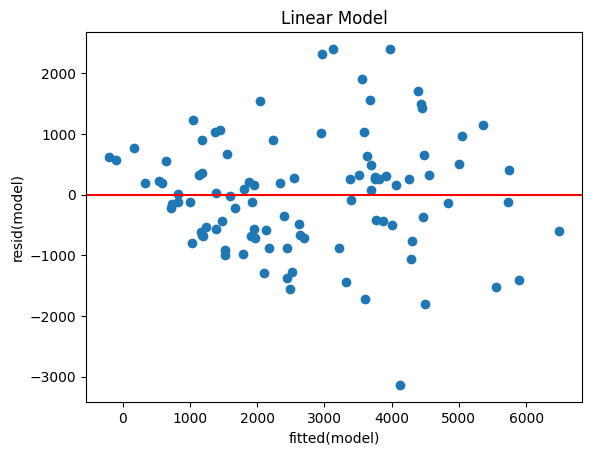

In [19]:
import os
if not os.path.exists( 'GNI-Risk plots' ):
    os.mkdir( 'GNI-Risk plots' )
    
ypred = model.predict(xs)
plt.scatter(ypred, model.resid)
plt.axhline(y = 0.0, color = 'r', linestyle = '-') 
plt.xlabel("fitted(model)")
plt.ylabel("resid(model)")
plt.title("Linear Model")
plt.savefig( os.path.join( 'GNI-Risk plots', 'Fitted-vs-Resid' ) )
plt.show()


The data points fan out in a cone shape. That is not good. It indicates that we might want to try a log-linear model.

In [20]:
# Build the model
modelog = sm.OLS(np.log(yhat), xs).fit()
modelog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     GNI per Capita 2019   R-squared:                       0.708
Model:                             OLS   Adj. R-squared:                  0.666
Method:                  Least Squares   F-statistic:                     17.15
Date:                 Thu, 14 Dec 2023   Prob (F-statistic):           5.99e-18
Time:                         22:04:57   Log-Likelihood:                -58.508
No. Observations:                   98   AIC:                             143.0
Df Residuals:                       85   BIC:                             176.6
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
===================================================================================================================================================
                                                                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                               7.8555      0.170     46.282      0.000       7.518       8.193
Deaths ...low birth weight, in both sexes aged all ages                            -0.0036      0.004     -0.953      0.343      -0.011       0.004
Deaths ...high body-mass index, in both sexes aged all ages                         0.0029      0.003      0.883      0.379      -0.004       0.009
Deaths ...household air pollution from solid fuels, in both sexes aged all ages    -0.0110      0.003     -3.739      0.000      -0.017      -0.005
Deaths ...diet low in nuts and seeds, in both sexes aged all ages                  -0.0066      0.012     -0.535      0.594      -0.031       0.018
Deaths ...high fasting plasma glucose, in both sexes aged all ages                  0.0025      0.002      1.119      0.266      -0.002       0.007
Deaths ...child wasting, in both sexes aged all ages                                0.0107      0.004      2.661      0.009       0.003       0.019
Deaths ...no access to handwashing facility, in both sexes aged all ages           -0.0265      0.009     -2.827      0.006      -0.045      -0.008
Deaths ...alcohol use, in both sexes aged all ages                                  0.0029      0.003      0.934      0.353      -0.003       0.009
Deaths ...diet low in fruits, in both sexes aged all ages                          -0.0093      0.012     -0.793      0.430      -0.033       0.014
Deaths ...diet low in vegetables, in both sexes aged all ages                       0.0216      0.016      1.311      0.193      -0.011       0.054
Deaths ...smoking, in both sexes aged all ages                                      0.0029      0.002      1.426      0.157      -0.001       0.007
Deaths ...diet low in whole grains, in both sexes aged all ages                    -0.0084      0.007     -1.257      0.212      -0.022       0.005
==============================================================================
Omnibus:                        7.060   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.511
Skew:                          -0.580   Prob(JB):                       0.0386
Kurtosis:                       3.501   Cond. No.                         627.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

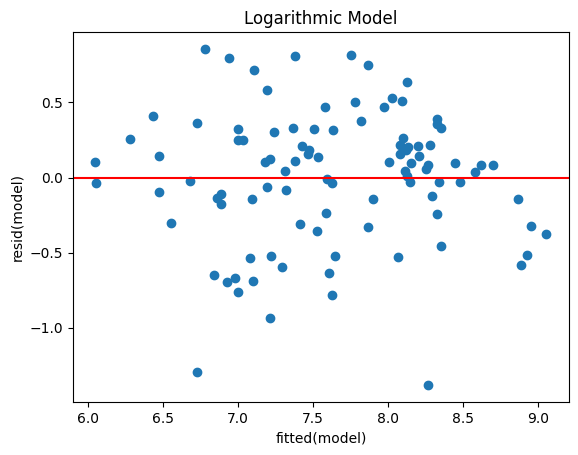

In [21]:
ypred = modelog.predict(xs)
plt.scatter(ypred, modelog.resid)
plt.axhline(y = 0.0, color = 'r', linestyle = '-') 
plt.xlabel("fitted(model)")
plt.ylabel("resid(model)")
plt.title("Logarithmic Model")
plt.savefig( os.path.join( 'GNI-Risk plots', 'Fitted-log-vs-Resid' ) )
plt.show()




Although the variance is slightly less flared out I don't think the improvement is sufficient to change to a log model. A log-linear model means that the terms become multiplicative. The exponent of the model Beta values become the coefficients in the multiplicative model. Changes in the independent variables become percent changes in the dependent variable. Since I am not convinced that this is the case I will keep the linear model for now.

A QQ plot plots the residual quantiles versus a theoretical normal distribution quantiles. The ideal result is a straight diagonal line.

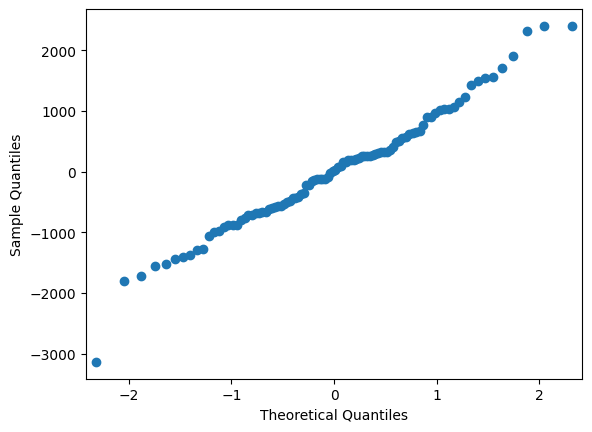

In [22]:
sm.qqplot(model.resid)
plt.savefig( os.path.join( 'GNI-Risk plots', 'QQPlot' ) )

Our QQ plot is quite straight except at the extreme tails. The plot indicates skew to the left

The histogram of residuals will tell us if the residuals are distributed around zero

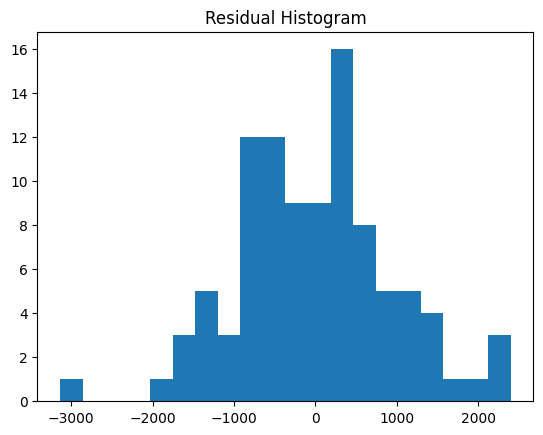

In [23]:

plt.hist(model.resid, bins=20)
plt.title('Residual Histogram')
plt.savefig( os.path.join( 'GNI-Risk plots', 'Resid Histogram' ) )

The histogram is centered around zero. The peaks are to the left and right but appear to be within one standard deviation

The last test is called Cook's Distance. It is a measure of outliers and influencers among the sample data points.

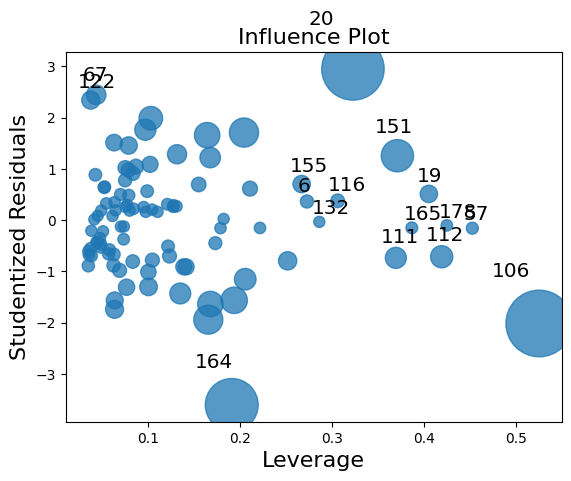

In [24]:
sm.graphics.influence_plot(model, external=True, alpha = 0.05)
plt.savefig( os.path.join( 'GNI-Risk plots', 'Cooks D' ) )
plt.show()

There are two high leverage points and one high 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=afeacf8c-bdd6-4dc6-a7d0-d44661b39e0f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>